In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.modeling.models import custom_model
from astropy.modeling import Fittable1DModel, Parameter
from astroquery.sdss import SDSS

In [2]:
# downlaods spectra of an M dwarf in the Sloan Digital Sky Survey 
spectrum = SDSS.get_spectra(plate=1349, fiberID=216, mjd=52797)[0]

In [3]:
# check contents of spectra
spectrum[1].columns

ColDefs(
    name = 'flux'; format = 'E'
    name = 'loglam'; format = 'E'
    name = 'ivar'; format = 'E'
    name = 'and_mask'; format = 'J'
    name = 'or_mask'; format = 'J'
    name = 'wdisp'; format = 'E'
    name = 'sky'; format = 'E'
    name = 'model'; format = 'E'
)

In [4]:
# gives flux in a function of wavelength
flux = spectrum[1].data['flux']
lam = 10**(spectrum[1].data['loglam'])

In [5]:
#Units of the flux
units_flux = spectrum[0].header['bunit']
print(units_flux)

1E-17 erg/cm^2/s/Ang


In [6]:
#Units of the wavelegth
units_wavelength_full = spectrum[0].header['WAT1_001']
print(units_wavelength_full)

wtype=linear label=Wavelength units=Angstroms


In [7]:
# only care about Angstroms
units_wavelength = units_wavelength_full[36:]
print(units_wavelength)

Angstroms


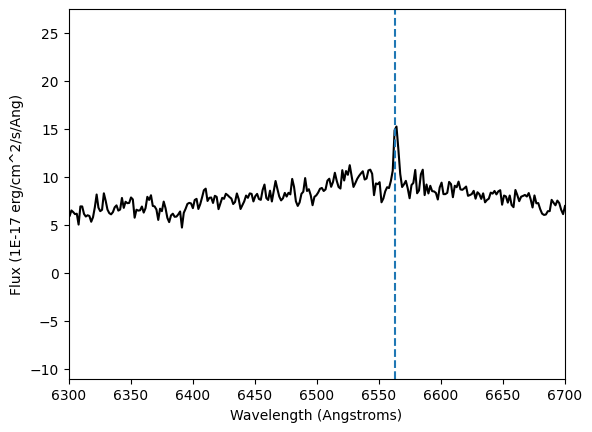

In [8]:
# plots spectrum with information from above
plt.plot(lam, flux, color='k')
plt.xlim(6300,6700)
plt.axvline(x=6563, linestyle='--')
plt.xlabel('Wavelength ({})'.format(units_wavelength))
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [9]:
# gives gausian model of spectrum
gausian_model = models.Gaussian1D(1, 6563, 10)
fitter = fitting.LevMarLSQFitter()
gaussian_fit = fitter(gausian_model, lam, flux)

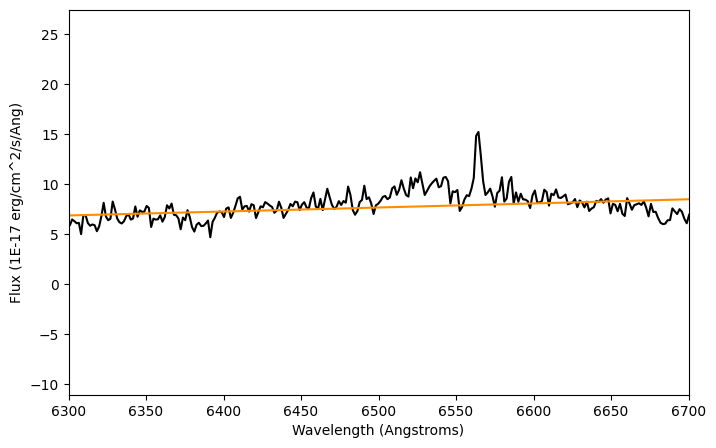

In [10]:
# plots the gaussian model
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, gaussian_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [11]:
# prints parameters of Gaussian fit
print(gaussian_fit)

Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude            mean             stddev     
    ----------------- ----------------- -----------------
    16.75070628912542 9456.749530943964 2368.395706441934


In [ ]:
'''

Exercise 1: Go back to the previous plot and try to make the fit work. 
Note: Do not spend more than 10 minutes in this exercise. 

A couple of ideas to try:

Is it not working because of the model we chose to fit? 
Is it not working because of the fitter we chose?
Is it not working because of the range of data we are fitting?
Is it not working because how we are plotting the data?

'''

In [12]:
# generates a compound model
compound_model = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)

In [13]:
# fits data using new model
fitter = fitting.LevMarLSQFitter()
compound_fit = fitter(compound_model, lam, flux)

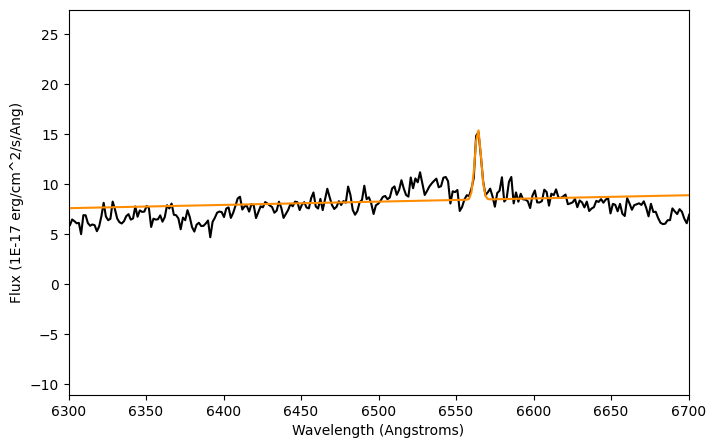

In [14]:
# plots data using new model
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [15]:
# prints parameters of the new model
print(compound_fit)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=7.02089174, mean=6564.13631715, stddev=1.97761476)>

    [1]: <Polynomial1D(1, c0=-12.79335619, c1=0.00323995)>
Parameters:
       amplitude_0          mean_0       ...          c1_1        
    ----------------- ------------------ ... ---------------------
    7.020891744278151 6564.1363171493185 ... 0.0032399520530058644


In [16]:
# another method to print parameters
for x,y in zip(compound_fit.param_names, compound_fit.parameters):
    print(x,y)

amplitude_0 7.020891744278151
mean_0 6564.1363171493185
stddev_0 1.9776147551998158
c0_1 -12.79335618554209
c1_1 0.0032399520530058644


In [17]:
# shows the amplitude of the model
compound_fit.amplitude_0

Parameter('amplitude', value=7.020891744278151)

In [18]:
# fixes parameteres of the compound model
compound_model_fixed = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
compound_model_fixed.mean_0.fixed = True

In [19]:
# fits the data with the new model
fitter = fitting.LevMarLSQFitter()
compound_fit_fixed = fitter(compound_model_fixed, lam, flux)

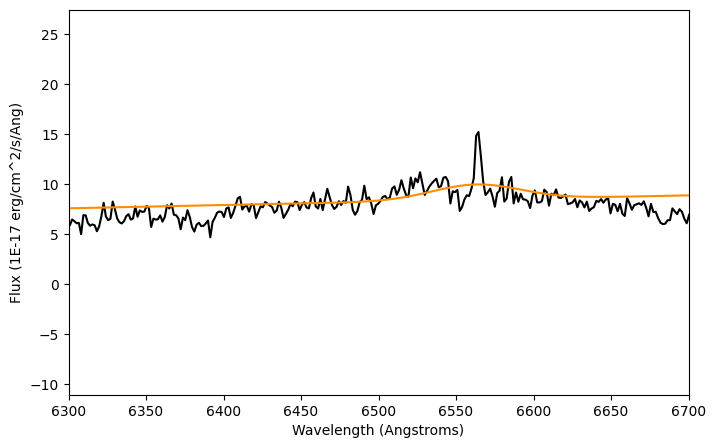

In [20]:
# plots the data with the new model
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_fixed(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [21]:
# prints parameters of the new model
print(compound_fit_fixed)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=1.53257471, mean=6563., stddev=28.57847528)>

    [1]: <Polynomial1D(1, c0=-12.79103, c1=0.00323745)>
Parameters:
       amplitude_0     mean_0 ...         c0_1                 c1_1        
    ------------------ ------ ... ------------------- ---------------------
    1.5325747104576728 6563.0 ... -12.791030002605527 0.0032374486280527933


In [22]:
# defines a minimum and maximum value for the mean
compound_model_bounded = models.Gaussian1D(1, 6563, 10) + models.Polynomial1D(degree=1)
delta = 0.5
compound_model_bounded.mean_0.max = 6563 + delta
compound_model_bounded.mean_0.min = 6563 - delta

fitter = fitting.LevMarLSQFitter()
compound_fit_bounded = fitter(compound_model_bounded, lam, flux)

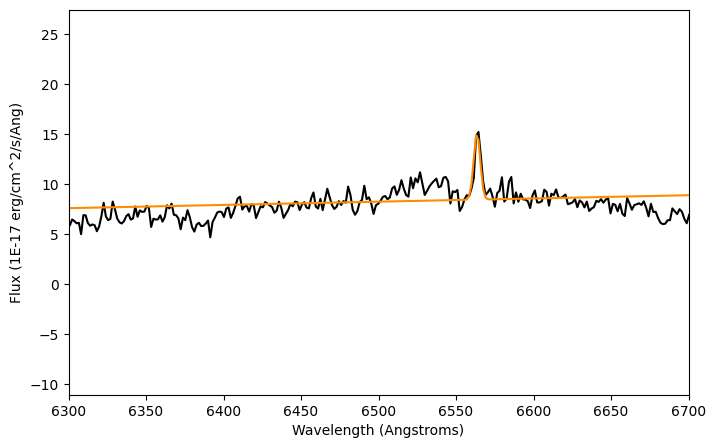

In [23]:
# plot with the minimum and maximum
plt.figure(figsize=(8,5))
plt.plot(lam, flux, color='k')
plt.plot(lam, compound_fit_bounded(lam), color='darkorange')
plt.xlim(6300,6700)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux ({})'.format(units_flux))
plt.show()

In [24]:
# prints parameters of the new bounded model
print(compound_fit_bounded)

Model: CompoundModel
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Expression: [0] + [1]
Components: 
    [0]: <Gaussian1D(amplitude=6.65730507, mean=6563.5, stddev=2.09182676)>

    [1]: <Polynomial1D(1, c0=-12.79336254, c1=0.00323995)>
Parameters:
       amplitude_0    mean_0 ...         c0_1                 c1_1        
    ----------------- ------ ... ------------------- ---------------------
    6.657305067408649 6563.5 ... -12.793362542046482 0.0032399500252079877


In [ ]:
'''

Exercise 2: Modify the value of delta to change the minimum and maximum values 
the mean of the gaussian. 

Look for:

The better delta so the mean is closer to the real value of the HÎ± line.
What is the minimum delta for which the fit is still good according to the plot?

'''

In [26]:
# simulates a data set for an exponential model
x1 = np.linspace(0,10,100)

a = 3
b = -2
c = 0
y1 = a*np.exp(b*x1+c)
y1 += np.random.normal(0., 0.2, x1.shape)
y1_err = np.ones(x1.shape)*0.2

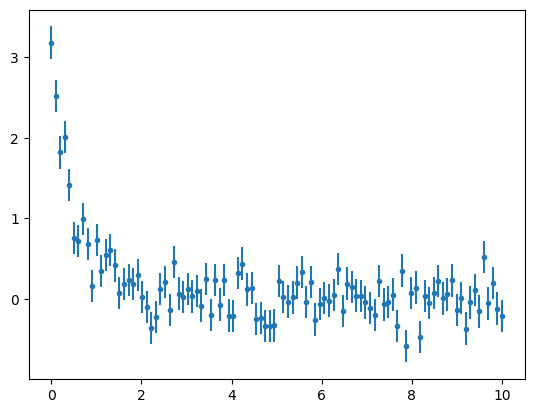

In [27]:
# plots the simulated data set
plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.show()

In [34]:
# specifies parameters for exponential model
@custom_model
def exponential(x, a=1., b=1., c=1.):
    '''
    f(x)=a*exp(b*x + c)
    '''
    return a*np.exp(b*x+c)

In [35]:
# fits data with new model
exp_model = exponential(1.,-1.,1.)  
fitter = fitting.LevMarLSQFitter()
exp_fit = fitter(exp_model, x1, y1, weights = 1.0/y1_err**2)

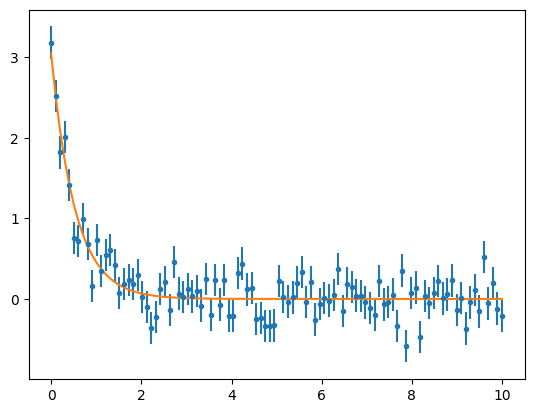

In [36]:
plt.errorbar(x1 , y1, yerr=y1_err, fmt='.')
plt.plot(x1, exp_fit(x1))
plt.show()

In [37]:
# prints parameters of custom exponential model
print(exp_fit)

Model: exponential
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                   b                  c         
    ------------------ ------------------- ------------------
    1.0516597859414814 -1.8979973384295912 1.0624922793682479


In [38]:
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

In [39]:
# generates chi square for fit
calc_reduced_chi_square(exp_fit(x1), x1, y1, y1_err, len(x1), 3)

1.2319956865013664

In [ ]:
'''

Exercise 3: Modify the initial conditions of the fit and check yourself the 
relation between the best fit parameters and the initial conditions for the 
previous example. You can check it by looking at the Reduced Chi Square value:
if it gets closer to 1 the fit is better and vice versa. To compare the quality
the fits you can take note of the Reduced Chi Square value you get for each 
initial condition.

'''

In [41]:
# simulates a data set for a sine function
x2 = np.linspace(0,10,100)
a = 3
b = 2
c = 4
d = 1
y2 = a*np.sin(b*x2+c)+d
y2 += np.random.normal(0., 0.5, x2.shape)
y2_err = np.ones(x2.shape)*0.3

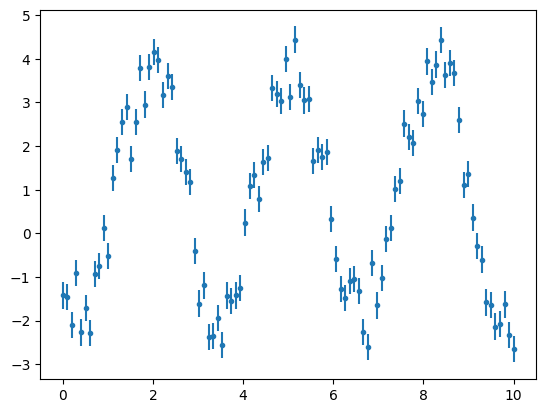

In [42]:
# plots this data set
plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.show()

In [44]:
# sets the derivative of the function for the custom sine model
class SineNew(Fittable1DModel):
    a = Parameter(default=1.)
    b = Parameter(default=1.)
    c = Parameter(default=1.)
    d = Parameter(default=1.)
        
    @staticmethod
    def evaluate(x, a, b, c, d):
        return a*np.sin(b*x+c)+d
    
    @staticmethod
    def fit_deriv(x, a, b, c, d):
        d_a = np.sin(b*x+c)
        d_b = a*np.cos(b*x+c)*x
        d_c = a*np.cos(b*x+c)
        d_d = np.ones(x.shape)
        return [d_a, d_b, d_c, d_d]

In [45]:
# fits data to the new sine model
sine_model = SineNew(a=4.,b=2.,c=4.,d=0.)  
fitter = fitting.LevMarLSQFitter()
sine_fit = fitter(sine_model, x2, y2, weights = 1.0/y2_err**2)

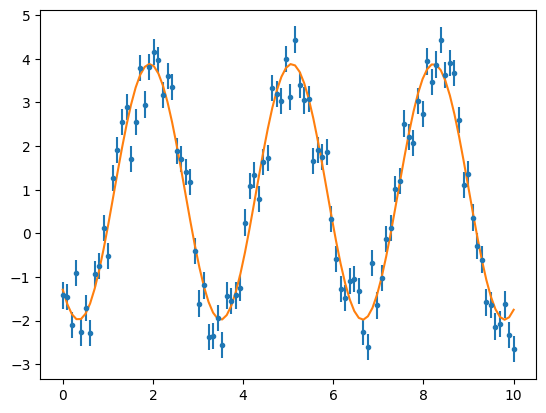

In [46]:
# plots data with the fit of the new model
plt.errorbar(x2, y2, yerr=y2_err, fmt='.')
plt.plot(x2,sine_fit(x2))
plt.show()

In [47]:
# prints parameters for the custom sine function
print(sine_fit)

Model: SineNew
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            a                 b                  c                 d         
    ----------------- ------------------ ----------------- ------------------
    2.931211537657222 1.9946777280928085 4.012728514728481 0.9498772464188988


In [48]:
# finds parameters and find the chi square value 
calc_reduced_chi_square(sine_fit(x2), x2, y2, y2_err, len(x2), 3)

3.14311334135566

In [ ]:
'''

Exercise 4: Play with the initial values for the last fit and improve the 
Reduced Chi Squared value.

'''

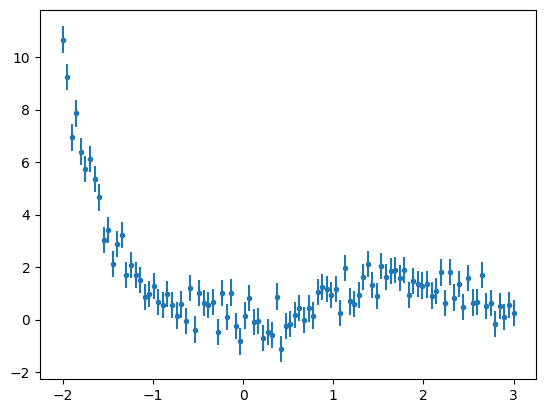

In [49]:
'''

Exercise 5: Custom models are also useful when we want to fit an unusual 
function to our data. As an example, create a full custom model to fit the 
following data.

'''

x3 = np.linspace(-2,3,100)
y3 = x3**2* np.exp(-0.5 * (x3)**3 / 2**2)
y3 += np.random.normal(0., 0.5, x3.shape)
y3_err = np.ones(x3.shape)*0.5

plt.errorbar(x3,y3,yerr=y3_err,fmt='.')
plt.show()